# Introduction and Setup

This project aims to classify images of cars into their respective make and model using the **Stanford Cars Dataset**. The model is fine-tuned using a pre-trained ResNet-18 architecture to achieve high accuracy in real-world scenarios.

### Key Objectives:
- Train and evaluate a deep learning model for car classification.
- Experiment with different hyperparameters and augmentations to improve performance.
- Deploy the model via an API for real-time usage.


In [48]:
# Standard Libraries
import os
import json
from pathlib import Path
from multiprocessing import set_start_method
import numpy as np
from scipy.io import loadmat

# Data Handling and Analysis
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_recall_fscore_support
)
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# Visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from tqdm.notebook import tqdm

# Image Handling and Augmentation
from PIL import Image
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.transforms.functional import to_pil_image

# PyTorch (Deep Learning Framework)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18, ResNet18_Weights
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Experiment Tracking and Utilities
import mlflow
from utils.image_processing import detect_and_blur_license_plate, parse_annotations
from utils.image_analysis import (
    extract_image_dimensions,
    plot_image_dimension_distributions,
    calculate_bounding_box_stats_with_actual_dimensions,
    plot_bounding_box_distributions,
    plot_samples_with_bboxes
)

# IPython (for Notebook Settings)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Miscellaneous
torch.multiprocessing.set_start_method("fork", force=True)


In [ ]:
# Constants for dataset paths
DATA_DIR = Path("data/raw/stanford-cars-dataset")
META_DIR = Path("data/raw/standford-cars-dataset-meta")

# Subdirectories
CARS_TEST_DIR = DATA_DIR / "cars_test/cars_test"
CARS_TRAIN_DIR = DATA_DIR / "cars_train/cars_train"

# Metadata files
CARS_ANNOS_TRAIN = META_DIR / "devkit/cars_train_annos.mat"
CARS_ANNOS_TEST = META_DIR / "cars_test_annos_withlabels (1).mat"
CARS_META_FILE = META_DIR / "devkit/cars_meta.mat"

# Processed data paths
CROPPED_TRAIN_DIR = Path("data/processed/cropped_train")
CROPPED_TEST_DIR = Path("data/processed/cropped_test")

In [ ]:

# Directories and metadata
root_dir = Path('data/raw/stanford-cars-dataset')
cars_test = root_dir / 'cars_test' / 'cars_test'
cars_train = root_dir / 'cars_train' / 'cars_train'

training_images = os.listdir(cars_train)
testing_images = os.listdir(cars_test)

root_dir = Path("data/raw/standford-cars-dataset-meta/")
cars_annos_train = root_dir / "devkit" / "cars_train_annos.mat"
cars_annos_test = root_dir / "cars_test_annos_withlabels (1).mat"

cars_meta_mat = loadmat(root_dir / "devkit" / "cars_meta.mat") #dict_keys(['__header__', '__version__', '__globals__', 'class_names'])
cars_annos_train_mat, cars_annos_test_mat = loadmat(cars_annos_train), loadmat(cars_annos_test) #dict_keys(['__header__', '__version__', '__globals__', 'annotations'])

class_names = [arr[0] for arr in cars_meta_mat['class_names'][0]]
with open("class_names.json", "w") as f:
    json.dump(class_names, f)


# Parse training and test annotations
bounding_boxes_train, class_labels_train, file_names_train = parse_annotations(cars_annos_train_mat['annotations'][0])
bounding_boxes_test, class_labels_test, file_names_test = parse_annotations(cars_annos_test_mat['annotations'][0])



In [ ]:
# Initialize MLflow experiment
mlflow.set_experiment("ResNet18_Image_Classification")

<Experiment: artifact_location='file:///Users/danielmak/Documents/HTX/mlruns/461932302175787790', creation_time=1733847862345, experiment_id='461932302175787790', last_update_time=1733847862345, lifecycle_stage='active', name='ResNet18_Image_Classification', tags={}>

### Dataset Overview

The **Stanford Cars Dataset** contains 16,185 images across 196 car classes. Each image is annotated with a bounding box and class label.

- **Training Set:** 8,144 images
- **Testing Set:** 8,041 images
- **Classes:** 196 distinct car models
- **Annotations:** Bounding box coordinates for each image

# Data Exploration

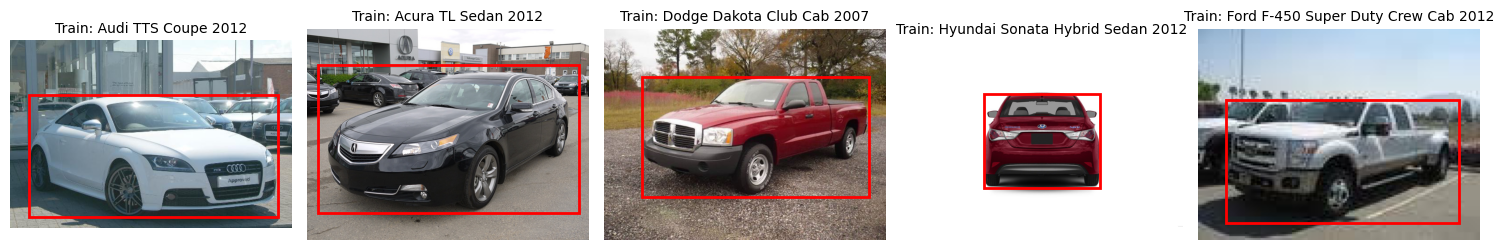

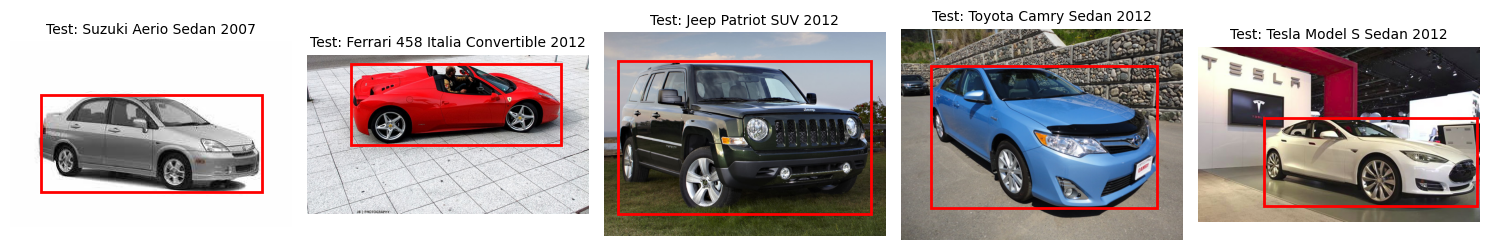

In [7]:
# Parameters
num_samples = 5  # Number of samples to display

# Plot training samples
plot_samples_with_bboxes(
    num_samples=num_samples,
    annotations=cars_annos_train_mat['annotations'][0],
    class_names=[name[0] for name in cars_meta_mat['class_names'][0]],
    cars_dir=cars_train,
    dataset_type="train"
)

# Plot test samples
plot_samples_with_bboxes(
    num_samples=num_samples,
    annotations=cars_annos_test_mat['annotations'][0],
    class_names=[name[0] for name in cars_meta_mat['class_names'][0]],
    cars_dir=cars_test,
    dataset_type="test"
)


Top 5 Train Classes and Frequency:
class_name
GMC Savana Van 2012                         68
Chrysler 300 SRT-8 2010                     49
Mercedes-Benz 300-Class Convertible 1993    48
Mitsubishi Lancer Sedan 2012                48
Jaguar XK XKR 2012                          47
Name: count, dtype: int64
Bottom 5 Train Classes and Frequency:
class_name
Rolls-Royce Phantom Drophead Coupe Convertible 2012    31
Chevrolet Express Cargo Van 2007                       30
Maybach Landaulet Convertible 2012                     29
FIAT 500 Abarth 2012                                   28
Hyundai Accent Sedan 2012                              24
Name: count, dtype: int64


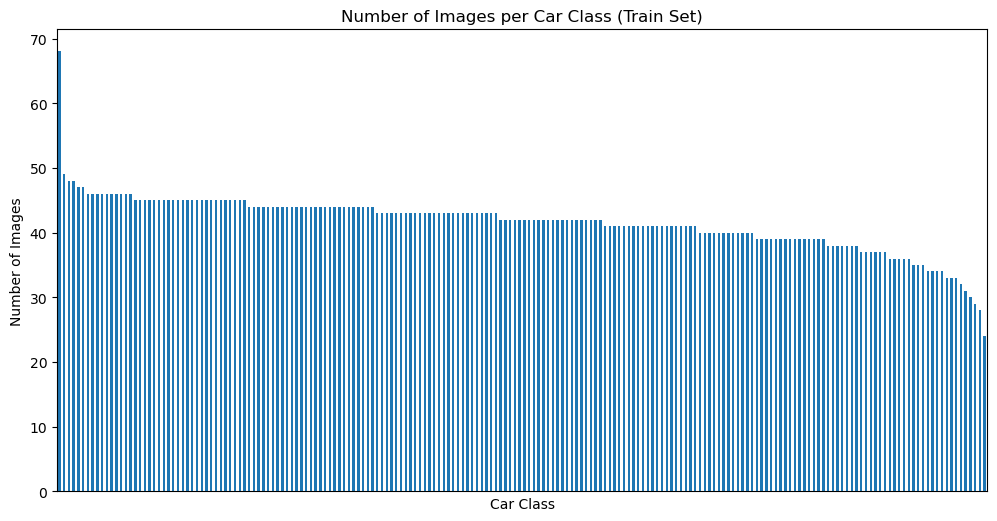

Top 5 Test Classes and Frequency:
class_name
GMC Savana Van 2012                         68
Mercedes-Benz 300-Class Convertible 1993    48
Chrysler 300 SRT-8 2010                     48
Mitsubishi Lancer Sedan 2012                47
Chevrolet Corvette ZR1 2012                 46
Name: count, dtype: int64
Bottom 5 Test Classes and Frequency:
class_name
Rolls-Royce Phantom Drophead Coupe Convertible 2012    30
Maybach Landaulet Convertible 2012                     29
Chevrolet Express Cargo Van 2007                       29
FIAT 500 Abarth 2012                                   27
Hyundai Accent Sedan 2012                              24
Name: count, dtype: int64


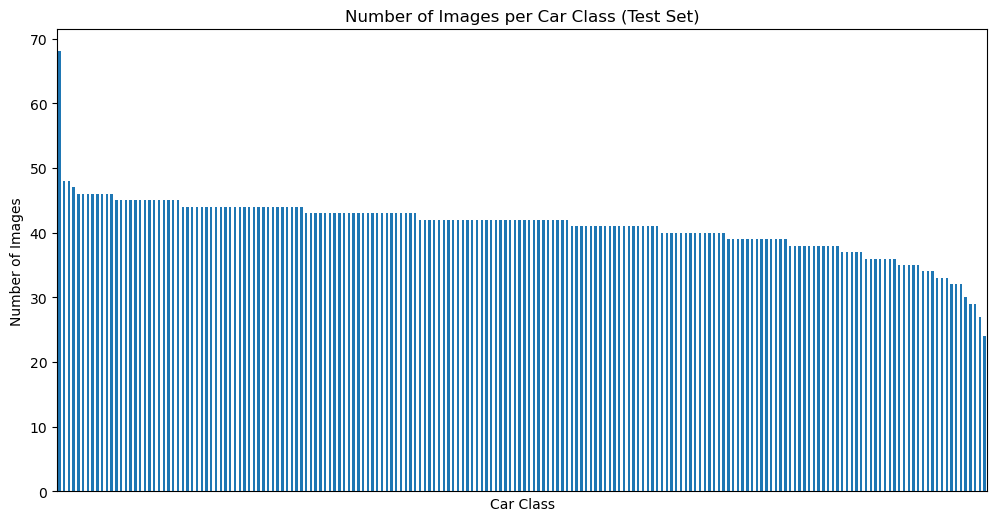

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

def get_class_distribution(annotations, class_names):
    """
    Extract class distribution from annotations.
    
    Args:
        annotations (list): List of annotations (train or test).
        class_names (list): List of class names.
    
    Returns:
        pd.DataFrame: DataFrame with file names, bounding box info, class IDs, and class names.
        pd.Series: Class distribution counts.
    """
    data = []
    for anno in annotations:
        x1 = anno['bbox_x1'][0][0]
        y1 = anno['bbox_y1'][0][0]
        x2 = anno['bbox_x2'][0][0]
        y2 = anno['bbox_y2'][0][0]
        class_id = anno['class'][0][0]
        file_name = anno['fname'][0]
        data.append([file_name, x1, y1, x2, y2, class_id, class_names[class_id - 1]])
    
    df = pd.DataFrame(data, columns=['file_name', 'x1', 'y1', 'x2', 'y2', 'class_id', 'class_name'])
    class_counts = df['class_name'].value_counts()
    return df, class_counts

def plot_class_distribution(class_counts, dataset_type="train"):
    """
    Plot class distribution as a bar chart.
    
    Args:
        class_counts (pd.Series): Class distribution counts.
        dataset_type (str): "train" or "test", for labeling the dataset.
    """
    plt.figure(figsize=(12, 6))
    class_counts.plot(kind='bar')
    plt.title(f"Number of Images per Car Class ({dataset_type.capitalize()} Set)")
    plt.xlabel("Car Class")
    plt.ylabel("Number of Images")
    plt.xticks([])
    plt.show()

# Analyze train set
df_train, class_counts_train = get_class_distribution(
    cars_annos_train_mat['annotations'][0],
    [name[0] for name in cars_meta_mat['class_names'][0]]
)
print("Top 5 Train Classes and Frequency:")
print(class_counts_train.head(5))
print("Bottom 5 Train Classes and Frequency:")
print(class_counts_train.tail(5))
plot_class_distribution(class_counts_train, dataset_type="train")

# Analyze test set
df_test, class_counts_test = get_class_distribution(
    cars_annos_test_mat['annotations'][0],
    [name[0] for name in cars_meta_mat['class_names'][0]]
)
print("Top 5 Test Classes and Frequency:")
print(class_counts_test.head(5))
print("Bottom 5 Test Classes and Frequency:")
print(class_counts_test.tail(5))
plot_class_distribution(class_counts_test, dataset_type="test")


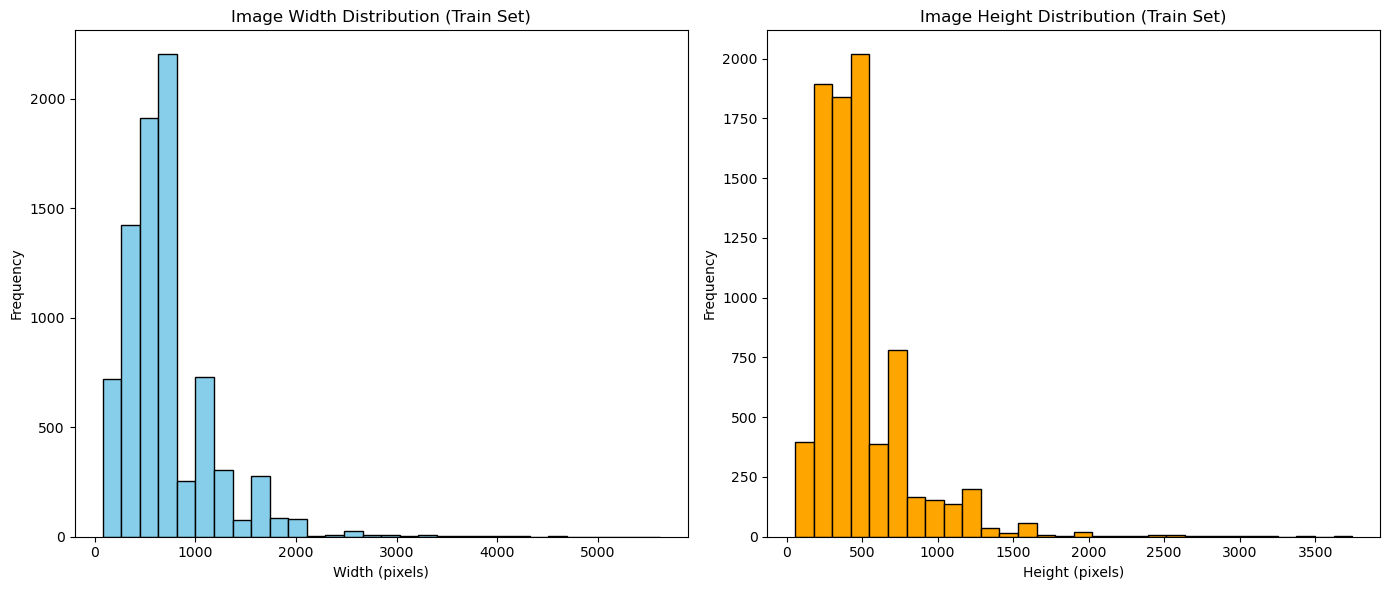

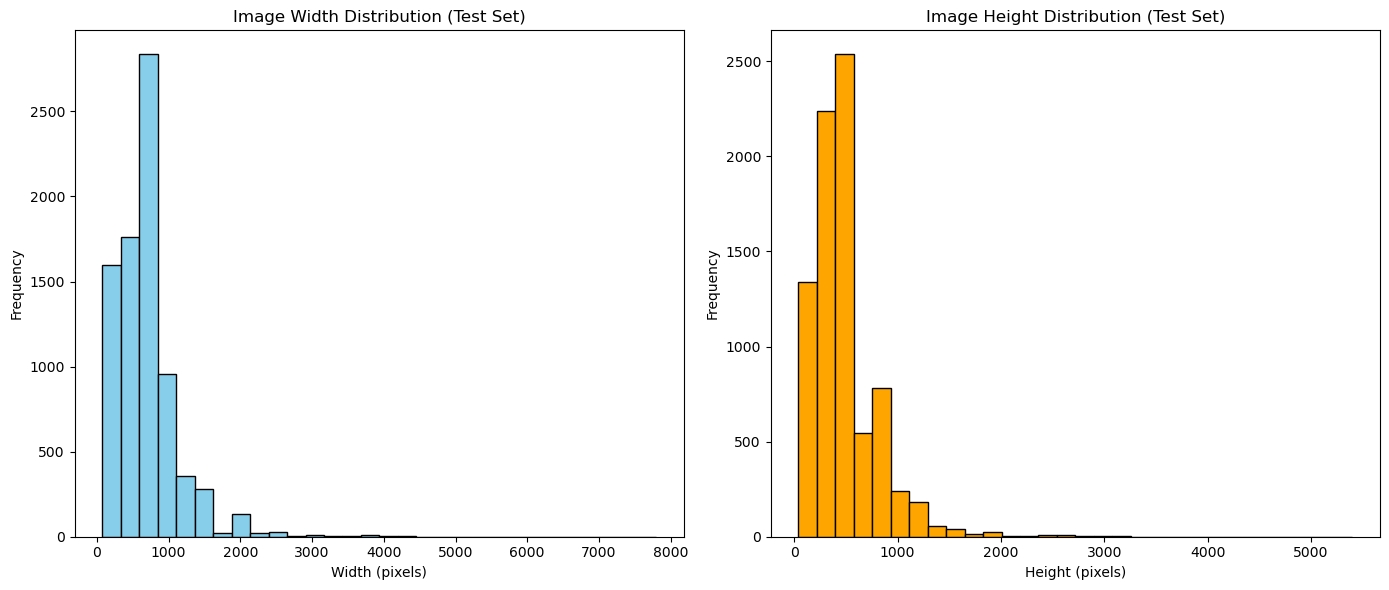

In [9]:

# Extract and plot image dimensions for train and test datasets
train_image_dimensions = extract_image_dimensions(cars_train)
test_image_dimensions = extract_image_dimensions(cars_test)

# Plot the distributions
plot_image_dimension_distributions(train_image_dimensions, dataset_type="train")
plot_image_dimension_distributions(test_image_dimensions, dataset_type="test")


Average Bounding Box Area Ratio (Train): 0.5445025405740077


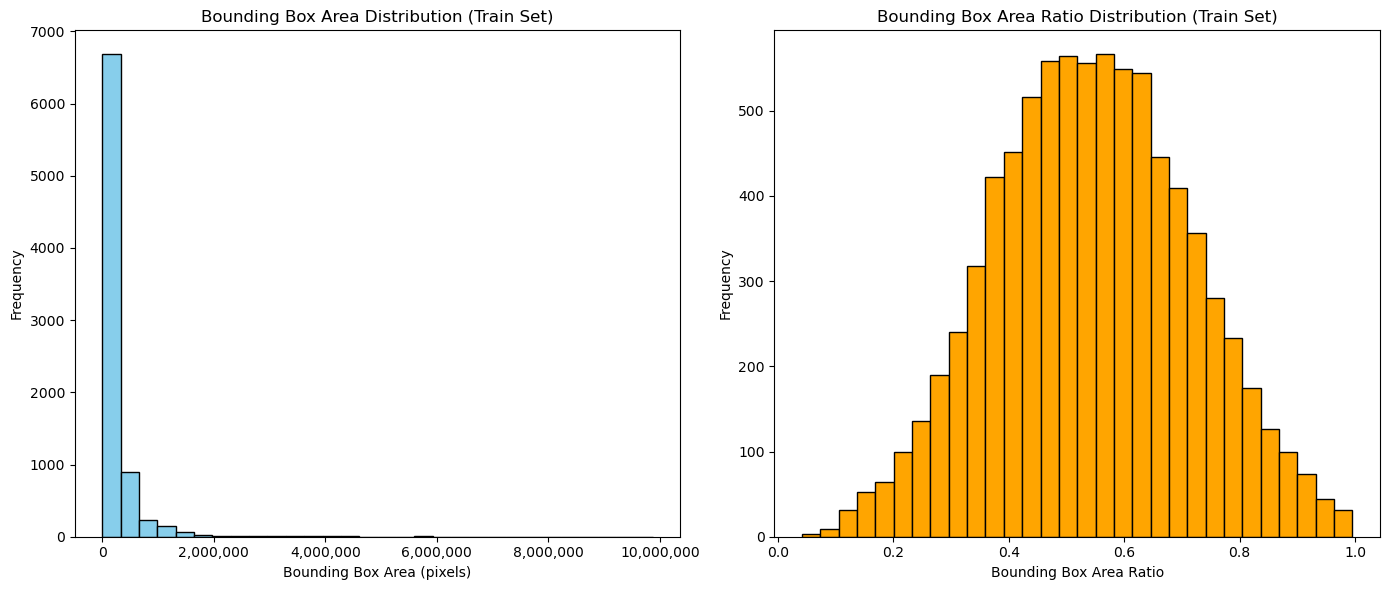

Average Bounding Box Area Ratio (Test): 0.5488241301767174


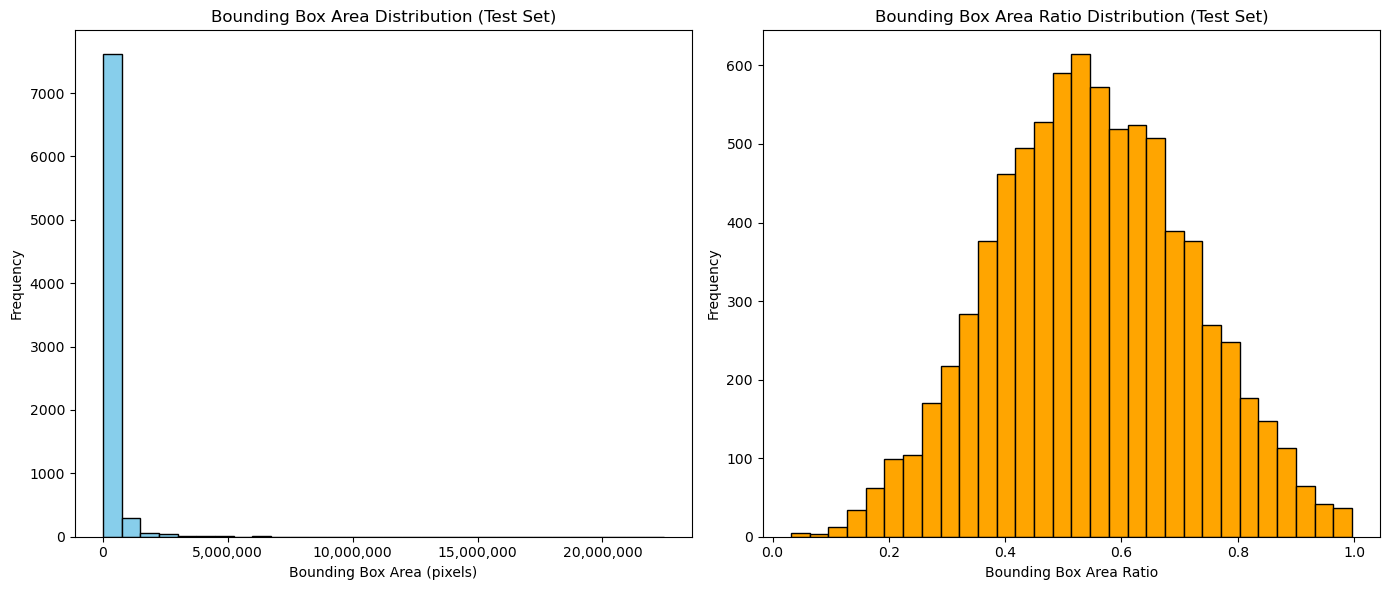

In [10]:
# Process train dataset
df_train_stats, avg_bbox_ratio_train = calculate_bounding_box_stats_with_actual_dimensions(df_train, cars_train)
print(f"Average Bounding Box Area Ratio (Train): {avg_bbox_ratio_train}")
plot_bounding_box_distributions(df_train_stats, dataset_type="train")

# Process test dataset
df_test_stats, avg_bbox_ratio_test = calculate_bounding_box_stats_with_actual_dimensions(df_test, cars_test)
print(f"Average Bounding Box Area Ratio (Test): {avg_bbox_ratio_test}")
plot_bounding_box_distributions(df_test_stats, dataset_type="test")



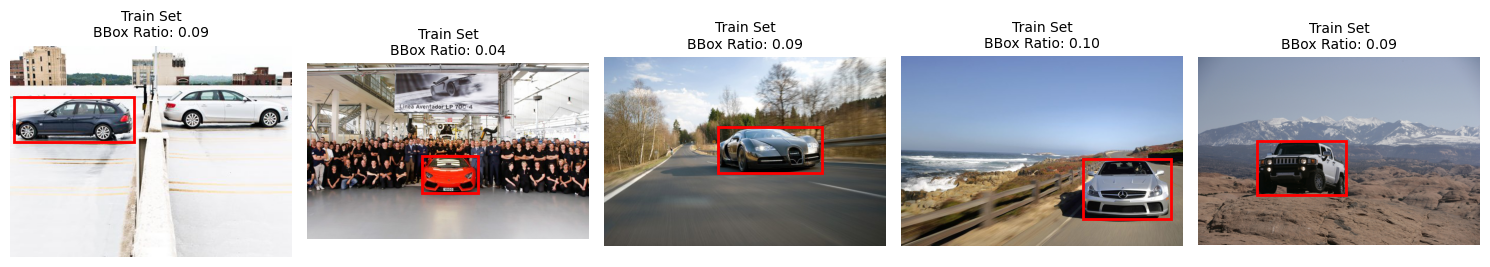

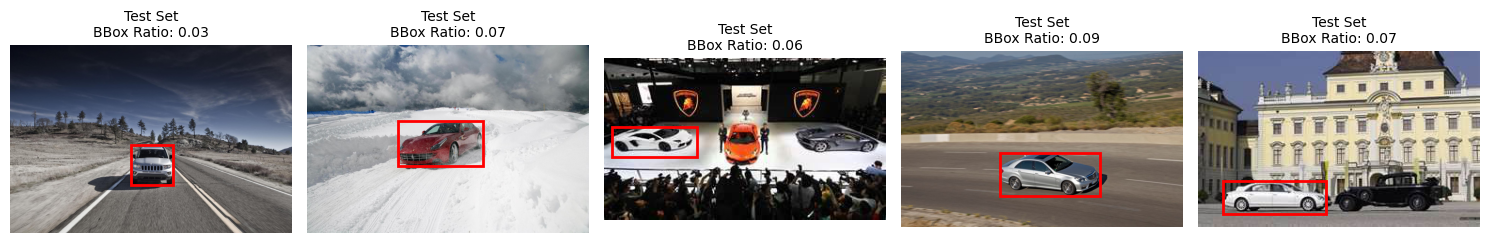

In [11]:
def visualize_low_ratio_images(df, cars_dir, ratio_threshold=0.1, num_samples=5, dataset_type="train"):
    """
    Visualize images with bounding box-to-image area ratio below a given threshold.
    
    Args:
        df (pd.DataFrame): DataFrame containing bounding box stats and area ratios.
        cars_dir (Path or str): Directory containing images.
        ratio_threshold (float): Threshold for bounding box area ratio.
        num_samples (int): Number of samples to display.
        dataset_type (str): "train" or "test", for labeling the dataset.
    """
    # Filter DataFrame for low area ratio
    low_ratio_df = df[df['bbox_area_ratio'] < ratio_threshold]
    
    # Select a few samples randomly
    sampled_rows = low_ratio_df.sample(min(num_samples, len(low_ratio_df)))
    
    plt.figure(figsize=(15, 10))  # Adjust figure size
    
    for idx, row in enumerate(sampled_rows.itertuples()):
        # Load image
        img_path = Path(cars_dir) / row.file_name
        if not img_path.exists():
            print(f"Warning: {row.file_name} does not exist in {cars_dir}. Skipping.")
            continue
        
        with Image.open(img_path) as img:
            # Plot image with bounding box
            plt.subplot(1, num_samples, idx + 1)
            plt.imshow(img)
            plt.gca().add_patch(plt.Rectangle(
                (row.x1, row.y1), row.bbox_width, row.bbox_height,
                edgecolor='red', facecolor='none', linewidth=2
            ))
            plt.title(f"{dataset_type.capitalize()} Set\nBBox Ratio: {row.bbox_area_ratio:.2f}", fontsize=10)
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize images with low bounding box area ratio for the training set
visualize_low_ratio_images(
    df=df_train_stats,
    cars_dir=cars_train,
    ratio_threshold=0.1,
    num_samples=5,
    dataset_type="train"
)

# Visualize images with low bounding box area ratio for the test set
visualize_low_ratio_images(
    df=df_test_stats,
    cars_dir=cars_test,
    ratio_threshold=0.1,
    num_samples=5,
    dataset_type="test"
)


Sample 1:
Image: 00873.jpg
Image Dimensions: Width=800, Height=540, Area=432000 pixels
Bounding Box: x1=517, y1=291, x2=765, y2=462
Bounding Box Dimensions: Width=248, Height=171, Area=42408 pixels
Bounding Box Area Ratio: 0.0982



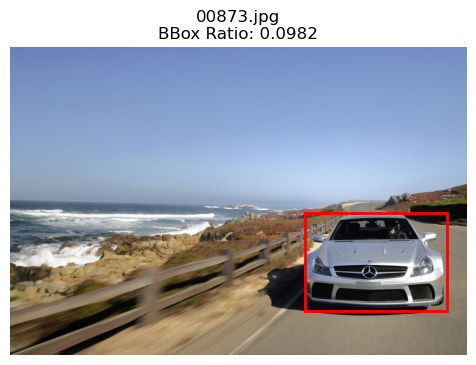

Sample 2:
Image: 05597.jpg
Image Dimensions: Width=623, Height=389, Area=242347 pixels
Bounding Box: x1=253, y1=204, x2=377, y2=286
Bounding Box Dimensions: Width=124, Height=82, Area=10168 pixels
Bounding Box Area Ratio: 0.0420



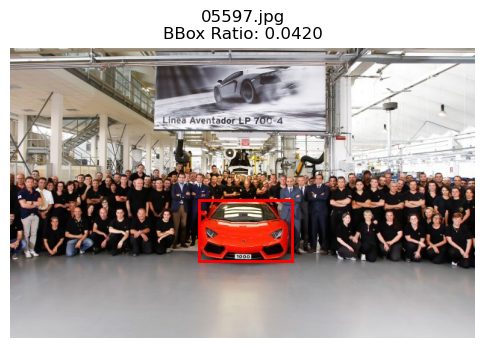

Sample 3:
Image: 01632.jpg
Image Dimensions: Width=586, Height=421, Area=246706 pixels
Bounding Box: x1=118, y1=53, x2=217, y2=230
Bounding Box Dimensions: Width=99, Height=177, Area=17523 pixels
Bounding Box Area Ratio: 0.0710



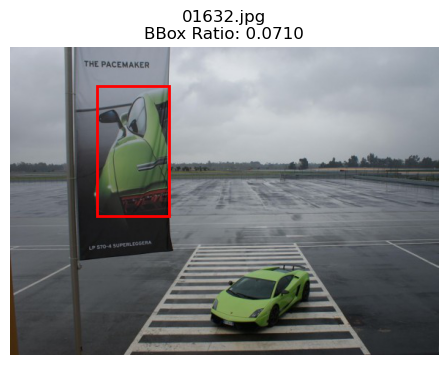

In [12]:
def display_low_bbox_ratio_details(df, cars_dir, ratio_threshold=0.1, num_samples=3):
    """
    Display bounding box dimensions, image dimensions, and bounding box ratio 
    for samples where the bounding box area ratio is below the threshold.
    
    Args:
        df (pd.DataFrame): DataFrame containing bounding box and image dimensions.
        cars_dir (Path or str): Directory containing images.
        ratio_threshold (float): Threshold for bounding box area ratio.
        num_samples (int): Number of samples to display.
    """
    # Filter rows where bounding box area ratio is below the threshold
    low_ratio_rows = df[df['bbox_area_ratio'] < ratio_threshold]
    
    if low_ratio_rows.empty:
        print("No samples found with bounding box area ratio below the threshold.")
        return
    
    # Select random samples from the filtered rows
    sampled_rows = low_ratio_rows.sample(min(num_samples, len(low_ratio_rows)))
    
    for idx, row in enumerate(sampled_rows.itertuples()):
        # Load image
        img_path = Path(cars_dir) / row.file_name
        if not img_path.exists():
            print(f"Warning: {row.file_name} does not exist in {cars_dir}. Skipping.")
            continue

        with Image.open(img_path) as img:
            # Extract bounding box and image dimensions
            image_width, image_height = img.size
            bbox_width = row.bbox_width
            bbox_height = row.bbox_height
            bbox_area = row.bbox_area
            image_area = image_width * image_height
            bbox_ratio = bbox_area / image_area
            
            # Display details
            print(f"Sample {idx + 1}:")
            print(f"Image: {row.file_name}")
            print(f"Image Dimensions: Width={image_width}, Height={image_height}, Area={image_area} pixels")
            print(f"Bounding Box: x1={row.x1}, y1={row.y1}, x2={row.x2}, y2={row.y2}")
            print(f"Bounding Box Dimensions: Width={bbox_width}, Height={bbox_height}, Area={bbox_area} pixels")
            print(f"Bounding Box Area Ratio: {bbox_ratio:.4f}\n")
            
            # Plot the image with bounding box
            plt.figure(figsize=(6, 4))
            plt.imshow(img)
            plt.gca().add_patch(plt.Rectangle(
                (row.x1, row.y1), bbox_width, bbox_height,
                edgecolor='red', facecolor='none', linewidth=2
            ))
            plt.title(f"{row.file_name}\nBBox Ratio: {bbox_ratio:.4f}")
            plt.axis('off')
            plt.show()

# Check bounding box ratio computation for samples with ratio < 0.1 in the training set
display_low_bbox_ratio_details(df_train_stats, cars_train, ratio_threshold=0.1, num_samples=3)


In [13]:
ENABLE_PLATE_DETECTION = False

## Cropping the images with the bounding boxes

In [13]:
# Create output directories for cropped images
cropped_train_dir = Path('data/processed/cropped_train')
cropped_train_dir.mkdir(parents=True, exist_ok=True)
cropped_test_dir = Path('data/processed/cropped_test')
cropped_test_dir.mkdir(parents=True, exist_ok=True)

In [15]:
# Function to crop and save images
def crop_and_save_images(file_names, bounding_boxes, source_dir, target_dir):
    """
    Crop and save images if they don't already exist.

    Args:
        file_names (list): List of image file names.
        bounding_boxes (list): List of bounding boxes (x1, y1, x2, y2).
        source_dir (Path): Path to the source directory containing raw images.
        target_dir (Path): Path to save the cropped images.
    """
    target_dir.mkdir(parents=True, exist_ok=True)  # Ensure target directory exists

    # Check if images already exist
    if len(list(target_dir.glob("*.jpg"))) == len(file_names):
        print(f"Images already cropped and saved in {target_dir}. Skipping cropping.")
        return

    print(f"Cropping and saving images to {target_dir}...")
    for i, bbox in tqdm(enumerate(bounding_boxes), total=len(bounding_boxes)):
        file_name = file_names[i]
        x1, y1, x2, y2 = bbox

        # Load image
        img_path = source_dir / file_name
        if not img_path.exists():
            print(f"Warning: {img_path} does not exist. Skipping.")
            continue

        # Crop and save the image
        with Image.open(img_path) as img:
            cropped_img = img.crop((x1, y1, x2, y2))
            cropped_img.save(target_dir / file_name)

    print(f"Cropping completed. Images saved to {target_dir}.")

# Only crop if the images are not already processed
if not (cropped_train_dir.exists() and cropped_test_dir.exists()):
    # Ensure the directory structure exists
    cropped_train_dir.mkdir(parents=True, exist_ok=True)
    cropped_test_dir.mkdir(parents=True, exist_ok=True)

    # Crop training and test images
    crop_and_save_images(file_names_train, bounding_boxes_train, cars_train, cropped_train_dir)
    crop_and_save_images(file_names_test, bounding_boxes_test, cars_test, cropped_test_dir)
else:
    print("Cropped directories already exist. Skipping cropping step.")


Cropped directories already exist. Skipping cropping step.


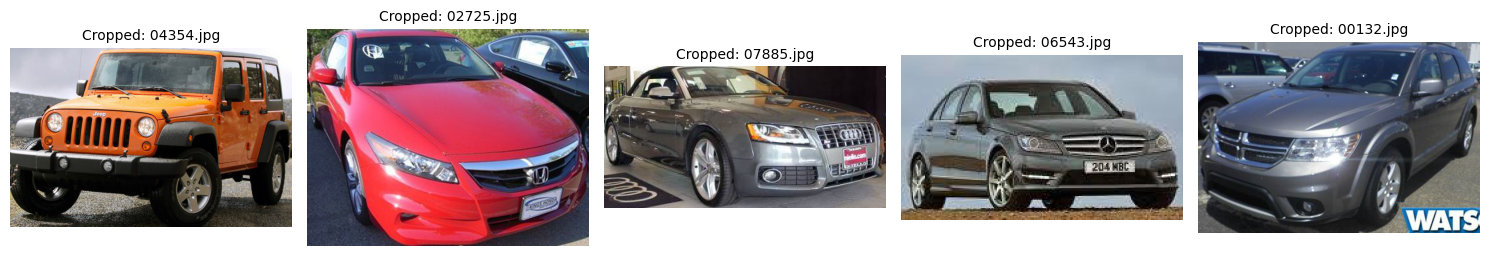

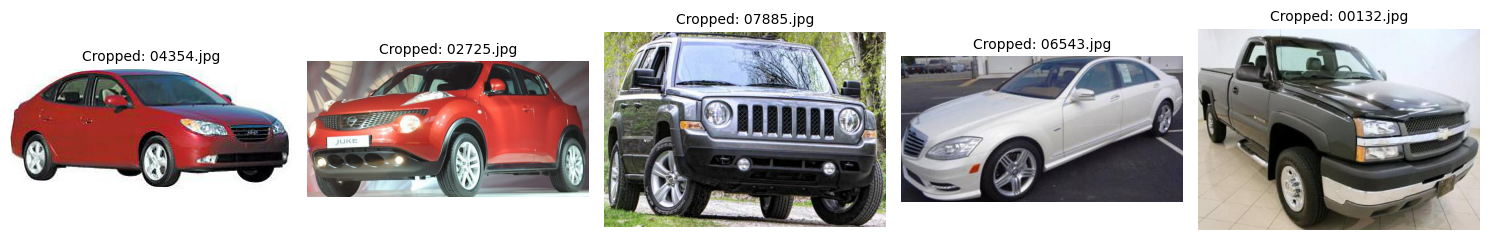

In [16]:
# Function to display a few cropped images for verification
def display_cropped_images(cropped_dir, num_images=5):
    cropped_files = list(cropped_dir.iterdir())[:num_images]
    plt.figure(figsize=(15, 10))
    for i, file_path in enumerate(cropped_files):
        img = Image.open(file_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"Cropped: {file_path.name}", fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display some cropped training images
display_cropped_images(cropped_train_dir, num_images=5)

# Display some cropped test images
display_cropped_images(cropped_test_dir, num_images=5)


## Problem Analysis and Critical Thinking

1) Bounding boxes in the dataset suggest an opportunity for pre-processing using localization techniques.
- Will be asessing whether cropping the image with the bounding boxes meaningfully improve the classification model's performance

2) Since car images might vary in real-world scenarios (low-light, partial occlusions), there might be a need to use data augmentation strategies to simulate these scenarios

3) Usage of object detection models for integrated car locatlization and type classification

4) Security Considerations:
- Highlight strategies to secure the API:
- Add rate limiting to prevent abuse.
- Validate input files to avoid malicious uploads.
Use HTTPS and authentication tokens.

cars_meta.mat contains a nested dictionary with Metadata information on the date the file was created. the class_names attribute contains all the names of the car labels

In [10]:


# Parse annotations into dictionaries
training_image_label_dict, testing_image_label_dict = {}, {}

for arr in cars_annos_train_mat['annotations'][0]:
    image, label = arr[-1][0], arr[-2][0][0] - 1
    training_image_label_dict[image] = label

for arr in cars_annos_test_mat['annotations'][0]:
    image, label = arr[-1][0], arr[-2][0][0] - 1
    testing_image_label_dict[image] = label

In [11]:

# Split the test set into validation and remaining test set
test_filenames = list(testing_image_label_dict.keys())
test_labels = list(testing_image_label_dict.values())

# Stratified split: 20% for validation, 80% for test
test_indices, val_indices = train_test_split(
    range(len(test_filenames)),
    test_size=0.2,               # 20% for validation
    stratify=test_labels,        # Preserve class distribution
    random_state=42
)

# Create validation and updated test dictionaries
validation_image_label_dict = {test_filenames[i]: test_labels[i] for i in val_indices}
updated_testing_image_label_dict = {test_filenames[i]: test_labels[i] for i in test_indices}

print(f"Original test set size: {len(testing_image_label_dict)}")
print(f"Validation set size: {len(validation_image_label_dict)}")
print(f"Updated test set size: {len(updated_testing_image_label_dict)}")


Original test set size: 8041
Validation set size: 1609
Updated test set size: 6432


# Load Data

In [19]:
# Define image size
image_size = (224, 224)

# Define the augmentation pipeline
augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussianBlur(blur_limit=(3, 5), p=0.3),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    A.Resize(image_size[0], image_size[1]),  # Ensure uniform size
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# Define a basic transformation pipeline for non-augmented images
basic_pipeline = A.Compose([
    A.Resize(image_size[0], image_size[1]),  # Ensure uniform size
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# Define the dataset class
class StanfordCarsDataset(Dataset):
    def __init__(self, image_label_dict, root_dir, use_augmentation=False):
        """
        Custom dataset class for Stanford Cars dataset.
        Args:
            image_label_dict: Dictionary of image filenames and their corresponding labels.
            root_dir: Directory containing the images.
            use_augmentation: Boolean flag to toggle augmentation on or off.
        """
        self.image_label_dict = image_label_dict
        self.root_dir = root_dir
        self.use_augmentation = use_augmentation

    def __len__(self):
        return len(self.image_label_dict)

    def __getitem__(self, idx):
        image_filename = list(self.image_label_dict.keys())[idx]
        label = self.image_label_dict[image_filename]
        image_path = self.root_dir / image_filename
        image = Image.open(image_path).convert("RGB")
        img_np = np.array(image)  # Convert PIL Image to NumPy array

        # Apply license plate detection if enabled
        if ENABLE_PLATE_DETECTION:
            img_np = detect_and_blur_license_plate(img_np)

        # Apply augmentation or basic transformation
        if self.use_augmentation:
            transformed = augmentation_pipeline(image=img_np)
        else:
            transformed = basic_pipeline(image=img_np)

        image = transformed["image"]
        return image, label

# Instantiate datasets
train_dataset = StanfordCarsDataset(
    training_image_label_dict,
    cropped_train_dir,
    use_augmentation=True  # Enable augmentations for training
)

val_dataset = StanfordCarsDataset(
    validation_image_label_dict,  # New validation set
    cropped_test_dir,
    use_augmentation=False
)

test_dataset = StanfordCarsDataset(
    updated_testing_image_label_dict,  # Updated test set
    cropped_test_dir,
    use_augmentation=False
)

# Use ResNet-18's transformation parameters
weights = ResNet18_Weights.DEFAULT
transform = weights.transforms()

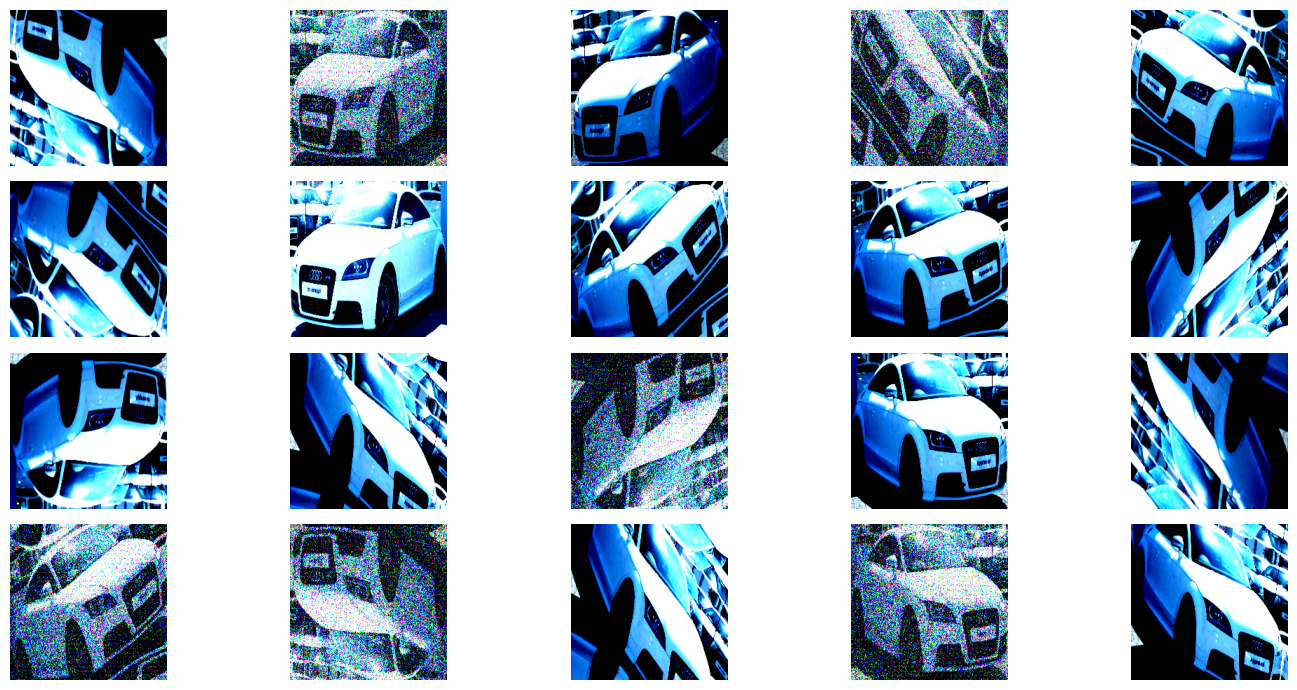

In [20]:

import copy

def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    """
    Visualize augmented versions of a single image in a dataset.
    
    Args:
        dataset (Dataset): The dataset containing the images and augmentations.
        idx (int): The index of the image in the dataset to visualize.
        samples (int): The number of augmented samples to generate.
        cols (int): The number of columns in the visualization grid.
    """
    # Deep copy the dataset to avoid modifying the original
    dataset = copy.deepcopy(dataset)
    
    # Remove normalization and tensor conversion transforms
    if hasattr(dataset, "transform") and dataset.transform:
        dataset.transform = A.Compose([
            t for t in dataset.transform.transforms 
            if not isinstance(t, (A.Normalize, ToTensorV2))
        ])
    
    # Prepare grid for visualization
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 7))
    
    # Generate and display augmented images
    for i in range(samples):
        image, _ = dataset[idx]
        if isinstance(image, torch.Tensor):  # Convert tensor to NumPy
            image = image.permute(1, 2, 0).numpy()
        image = np.clip(image, 0, 1)  # Ensure pixel values are valid for display
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    
    plt.tight_layout()
    plt.show()

visualize_augmentations(train_dataset, idx=0, samples=20, cols=5)

# Model Architecture

In [22]:
batch_size = 32
learning_rate = 0.001
dropout = 0
weight_decay_values=0

# Early stopping parameters
patience = 3  # Number of epochs to wait for improvement
min_delta = 0.01  # Minimum change to qualify as improvement
best_val_loss = float('inf')  # Best validation loss observed
wait = 0  # Counter for patience

In [23]:

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


# Load pre-trained ResNet-18 model
model = resnet18(weights=weights)
# Freeze feature extractor layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze Layer 4
for param in model.layer4.parameters():
    param.requires_grad = True
#model.fc = nn.Linear(model.fc.in_features, len(class_names))  # Replace final layer with 196 classes

model.fc = nn.Sequential(
    nn.Dropout(p=dropout),  # Apply 50% dropout
    nn.Linear(model.fc.in_features, len(class_names))  # Output layer
)

# Ensure the new fc layer is trainable
for param in model.fc.parameters():
    param.requires_grad = True

# Transfer model to device
device = torch.device("mps" if torch.mps.is_available() else "cpu")
print(device)
model = model.to(device)



# optimizer = optim.Adam(model.parameters(), lr=learning_rate, , weight_decay=weight_decay_values)
# Parameterize the optimizer
# optimizer_name = optimizer.__class__.__name__

mps


In [ ]:

# Architecture log
architecture_description = "ResNet-18 with Classification Head 1 partial freeze"

/opt/miniconda3/envs/HTX-assessment/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


'ResNet18'

'Adam'

0.001

32

50

'ResNet-18 with Classification Head 1 partial freeze'

True

False

0

False

3

True

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 1/50:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [1/50], Train Loss: 4.8576, Train Accuracy: 5.10%, Val Loss: 3.6687, Val Accuracy: 14.79%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 2/50:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [2/50], Train Loss: 3.5357, Train Accuracy: 18.36%, Val Loss: 2.7101, Val Accuracy: 30.39%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 3/50:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [3/50], Train Loss: 2.7733, Train Accuracy: 31.45%, Val Loss: 2.1373, Val Accuracy: 40.71%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 4/50:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [4/50], Train Loss: 2.2901, Train Accuracy: 41.36%, Val Loss: 1.6942, Val Accuracy: 53.95%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 5/50:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [5/50], Train Loss: 2.0087, Train Accuracy: 47.95%, Val Loss: 1.4778, Val Accuracy: 56.68%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 6/50:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [6/50], Train Loss: 1.7661, Train Accuracy: 53.52%, Val Loss: 1.3749, Val Accuracy: 61.16%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 7/50:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [7/50], Train Loss: 1.6284, Train Accuracy: 57.12%, Val Loss: 1.2048, Val Accuracy: 65.01%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 8/50:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [8/50], Train Loss: 1.4728, Train Accuracy: 61.04%, Val Loss: 1.0668, Val Accuracy: 68.86%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 9/50:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [9/50], Train Loss: 1.3707, Train Accuracy: 63.64%, Val Loss: 1.0138, Val Accuracy: 69.24%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 10/50:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [10/50], Train Loss: 1.2699, Train Accuracy: 65.91%, Val Loss: 1.0550, Val Accuracy: 69.61%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 11/50:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [11/50], Train Loss: 1.2257, Train Accuracy: 66.77%, Val Loss: 0.9283, Val Accuracy: 72.16%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 12/50:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [12/50], Train Loss: 1.1224, Train Accuracy: 69.18%, Val Loss: 0.8523, Val Accuracy: 74.58%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 13/50:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [13/50], Train Loss: 1.0691, Train Accuracy: 70.36%, Val Loss: 0.8335, Val Accuracy: 75.26%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 14/50:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [14/50], Train Loss: 1.0263, Train Accuracy: 71.57%, Val Loss: 0.8268, Val Accuracy: 75.20%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 15/50:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [15/50], Train Loss: 1.0019, Train Accuracy: 72.45%, Val Loss: 0.8610, Val Accuracy: 74.70%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 16/50:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [16/50], Train Loss: 0.9086, Train Accuracy: 74.94%, Val Loss: 0.7656, Val Accuracy: 77.69%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 17/50:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [17/50], Train Loss: 0.9350, Train Accuracy: 74.20%, Val Loss: 0.7980, Val Accuracy: 75.82%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 18/50:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [18/50], Train Loss: 0.8744, Train Accuracy: 75.60%, Val Loss: 0.8283, Val Accuracy: 77.32%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 19/50:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [19/50], Train Loss: 0.8252, Train Accuracy: 76.90%, Val Loss: 0.7635, Val Accuracy: 78.31%
Early stopping triggered at epoch 19


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Test Loss: 0.8245, Test Accuracy: 77.41%
Test metrics and confusion matrix have been saved and logged to MLflow.


2024/12/18 01:04:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


<Figure size 1200x500 with 0 Axes>

<Axes: >

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Train and Validation Loss')

<Axes: >

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

Text(0.5, 1.0, 'Train and Validation Accuracy')

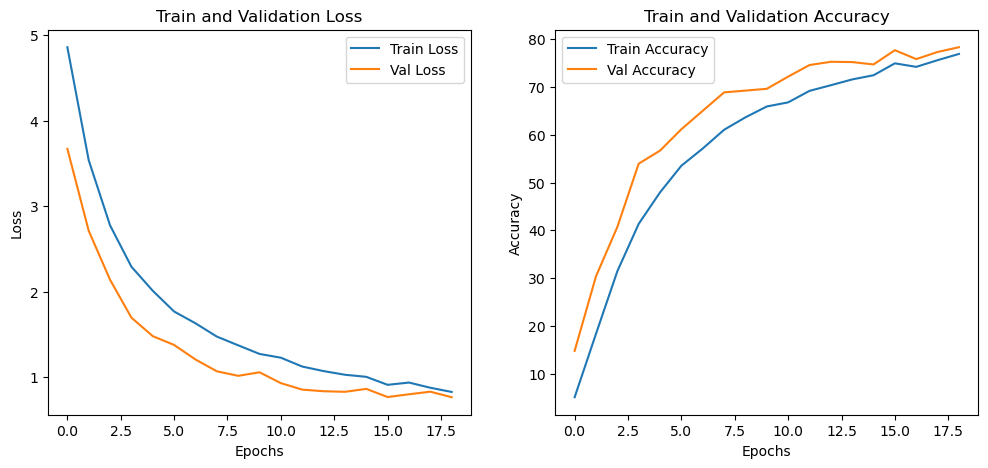

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer_name = optimizer.__class__.__name__

# Initialize ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 50

if mlflow.active_run():
    mlflow.end_run()
with mlflow.start_run(run_name=architecture_description):
    # Log model parameters
    mlflow.log_param("model", "ResNet18")
    mlflow.log_param("optimizer", optimizer_name)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("architecture", architecture_description)
    mlflow.log_param("use_cropped_images", True)
    mlflow.log_param("freeze_extractor_layers", False)
    mlflow.log_param("Dropout", dropout)
    mlflow.log_param("license_plate_blur", ENABLE_PLATE_DETECTION)
    mlflow.log_param("patience", patience)
    mlflow.log_param("use_augmentation", True)

    best_val_loss = float('inf')
    wait = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Log metrics to MLflow
        mlflow.log_metric("train_loss", train_loss, step=epoch + 1)
        mlflow.log_metric("train_accuracy", train_accuracy, step=epoch + 1)
        mlflow.log_metric("val_loss", val_loss, step=epoch + 1)
        mlflow.log_metric("val_accuracy", val_accuracy, step=epoch + 1)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
        
        # Step the scheduler
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        mlflow.log_metric("learning_rate", current_lr, step=epoch + 1)

        # Early stopping
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Final Test Phase
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_accuracy)

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Save confusion matrix as a DataFrame
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm_csv_path = "test_confusion_matrix.csv"
    cm_df.to_csv(cm_csv_path)

    # Log confusion matrix as an artifact
    mlflow.log_artifact(cm_csv_path, artifact_path="confusion_metrics")

    # Compute precision, recall, F1-score, and support for test set
    precision, recall, f1_score, support = precision_recall_fscore_support(
        all_labels, all_preds, average=None, labels=range(len(class_names))
    )

    # Create a DataFrame to store test metrics
    test_metrics_df = pd.DataFrame({
        'Class': class_names,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score,
        'Support': support
    })

    # Save test metrics to CSV
    test_metrics_csv_path = "test_classification_metrics.csv"
    test_metrics_df.to_csv(test_metrics_csv_path, index=False)

    # Log test metrics DataFrame as an artifact
    mlflow.log_artifact(test_metrics_csv_path, artifact_path="test_metrics")

    print("Test metrics and confusion matrix have been saved and logged to MLflow.")

    # Save and log the trained model as an artifact
    model_save_path = "models/final_model.pth"
    torch.save(model.state_dict(), model_save_path)  # Save locally for reference
    mlflow.log_artifact(model_save_path, artifact_path="models")  # Log the file as an artifact

    # Log the model directly to MLflow
    mlflow.pytorch.log_model(
        pytorch_model=model,
        artifact_path="ResNet18-model",
    )

    # Plot training/validation loss and accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train and Validation Accuracy')
    plt.legend()

    plt.savefig("learning_curves.png")
    mlflow.log_artifact("learning_curves.png", artifact_path="plots")
    plt.show()


In [ ]:
## Do some sample predictions and check the output against my image. 
## Rent collab to speed up model training with GPUs. Research ways to improve the model
## Commit code into Github with the commits. 
## Test out the docker file on mac docker engine. 

## Precision Recall and PR Curve

In [5]:
# Save the fine-tuned model
torch.save(model.state_dict(), "resnet18_finetuned_Adam_lr0.001_bs32_epoch5_10Dec_v1.pth")

In [30]:
for name, param in model.named_parameters():
    print(f"{name} requires_grad: {param.requires_grad}")

conv1.weight requires_grad: True
bn1.weight requires_grad: True
bn1.bias requires_grad: True
layer1.0.conv1.weight requires_grad: True
layer1.0.bn1.weight requires_grad: True
layer1.0.bn1.bias requires_grad: True
layer1.0.conv2.weight requires_grad: True
layer1.0.bn2.weight requires_grad: True
layer1.0.bn2.bias requires_grad: True
layer1.1.conv1.weight requires_grad: True
layer1.1.bn1.weight requires_grad: True
layer1.1.bn1.bias requires_grad: True
layer1.1.conv2.weight requires_grad: True
layer1.1.bn2.weight requires_grad: True
layer1.1.bn2.bias requires_grad: True
layer2.0.conv1.weight requires_grad: True
layer2.0.bn1.weight requires_grad: True
layer2.0.bn1.bias requires_grad: True
layer2.0.conv2.weight requires_grad: True
layer2.0.bn2.weight requires_grad: True
layer2.0.bn2.bias requires_grad: True
layer2.0.downsample.0.weight requires_grad: True
layer2.0.downsample.1.weight requires_grad: True
layer2.0.downsample.1.bias requires_grad: True
layer2.1.conv1.weight requires_grad: True


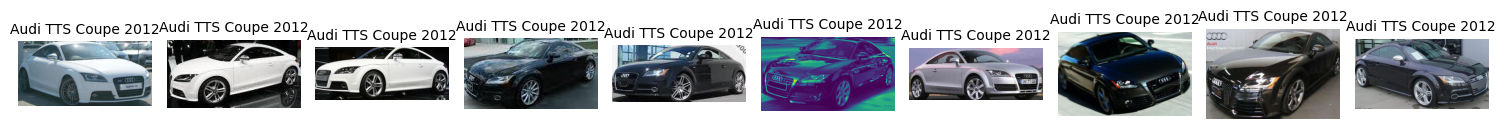

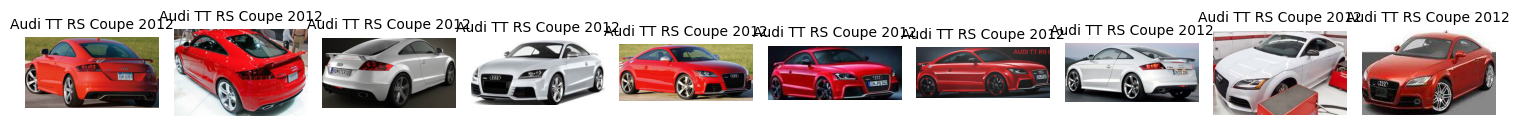

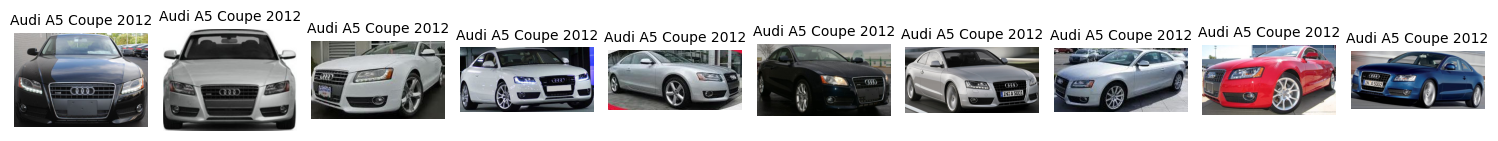

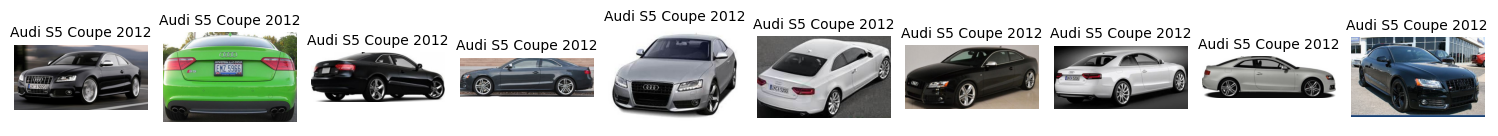

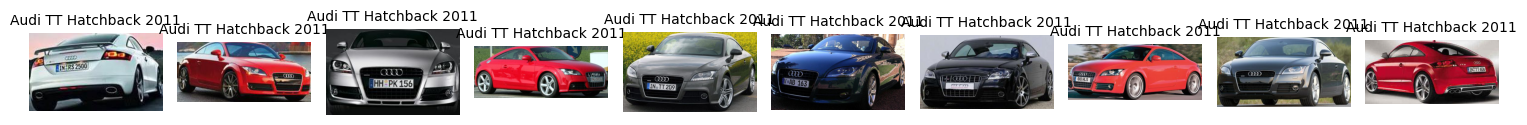

In [46]:
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import json

# Define the car models and their labels (update with your actual labels if available)
car_models = [
    "Audi TTS Coupe 2012",
    "Audi TT RS Coupe 2012",
    "Audi A5 Coupe 2012",
    "Audi S5 Coupe 2012",
    "Audi TT Hatchback 2011"
]

# Map class names to their respective labels
with open("class_names.json", "r") as f:
    class_names = json.load(f)
model_to_label = {model: class_names.index(model) for model in car_models}

# Function to plot images
def plot_car_samples(model_name, label, image_label_dict, image_dir, num_samples=5):
    """
    Plot a few samples of a specific car model from the dataset.
    Args:
        model_name (str): Name of the car model.
        label (int): Label corresponding to the car model.
        image_label_dict (dict): Dictionary of image file names and their labels.
        image_dir (Path): Path to the directory containing the images.
        num_samples (int): Number of samples to display.
    """
    # Filter images for the specific car model
    images = [img for img, lbl in image_label_dict.items() if lbl == label][:num_samples]

    # Display the images
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(images):
        img_path = image_dir / img_name
        with Image.open(img_path) as img:
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(img)
            plt.title(f"{model_name}", fontsize=10)
            plt.axis("off")
    plt.tight_layout()
    plt.show()

# Iterate over the specified car models and plot samples
for model_name, label in model_to_label.items():
    plot_car_samples(
        model_name=model_name,
        label=label,
        image_label_dict=training_image_label_dict,  # Use your training image-label dictionary
        image_dir=cropped_train_dir,  # Path to the training images
        num_samples=10
    )


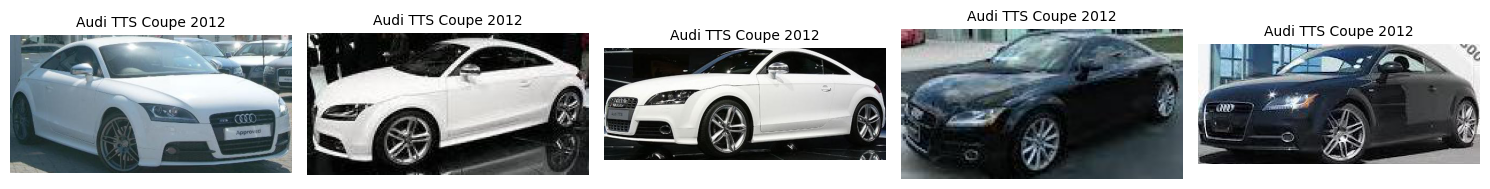

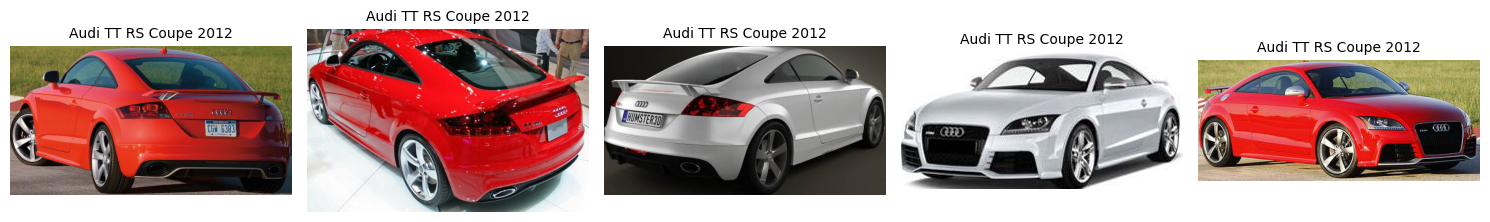

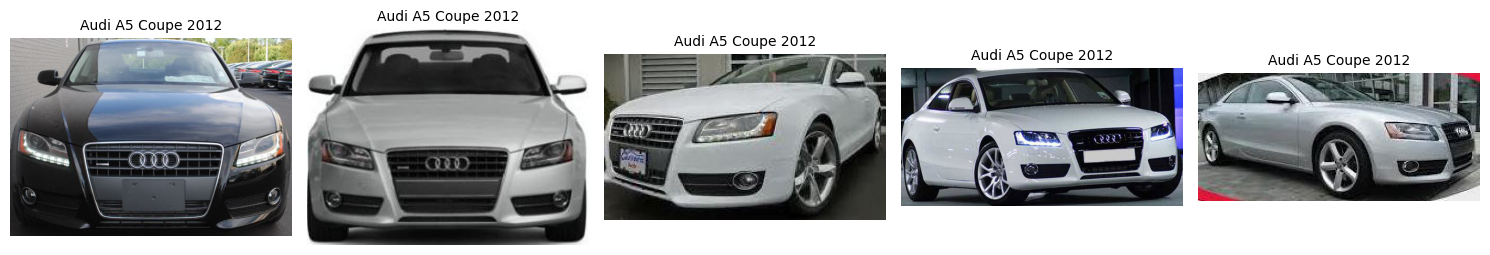

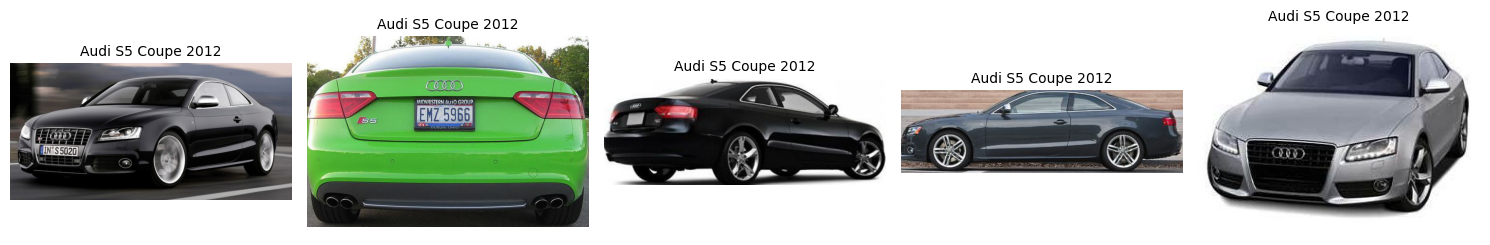

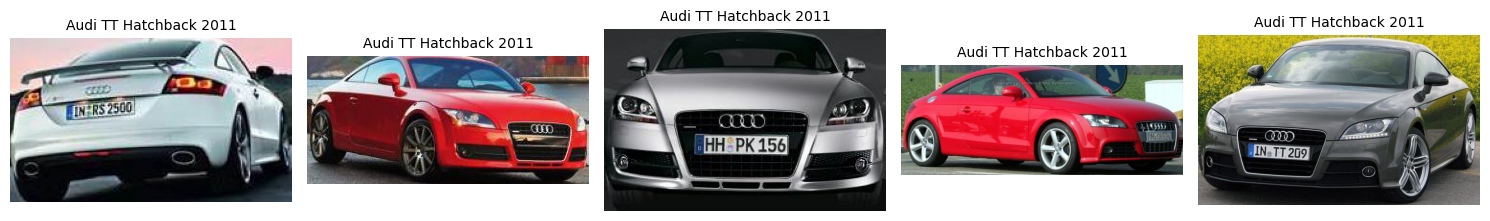

In [47]:
# Function to plot and save images
def plot_and_save_car_samples(model_name, label, image_label_dict, image_dir, output_dir, num_samples=5):
    """
    Plot and save a few samples of a specific car model from the dataset.
    
    Args:
        model_name (str): Name of the car model.
        label (int): Label corresponding to the car model.
        image_label_dict (dict): Dictionary of image file names and their labels.
        image_dir (Path): Path to the directory containing the images.
        output_dir (Path): Path to save the output images.
        num_samples (int): Number of samples to display.
    """
    # Filter images for the specific car model
    images = [img for img, lbl in image_label_dict.items() if lbl == label][:num_samples]
    
    # Ensure the output directory exists
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Display and save the images
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(images):
        img_path = image_dir / img_name
        with Image.open(img_path) as img:
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(img)
            plt.title(f"{model_name}", fontsize=10)
            plt.axis("off")
            
            # Save the individual image
            output_path = output_dir / f"{model_name.replace(' ', '_')}_sample_{i + 1}.png"
            img.save(output_path)
    
    plt.tight_layout()
    
    # Save the full figure
    figure_path = output_dir / f"{model_name.replace(' ', '_')}_samples.png"
    plt.savefig(figure_path)
    plt.show()

# Example usage
output_dir = Path("data/output")  # Directory to save the output images

for model_name, label in model_to_label.items():
    plot_and_save_car_samples(
        model_name=model_name,
        label=label,
        image_label_dict=training_image_label_dict,  # Use your training image-label dictionary
        image_dir=cropped_train_dir,  # Path to the training images
        output_dir=output_dir,  # Path to save output images
        num_samples=5
    )


## Analysis of Confusion Matrix

In [36]:
import pandas as pd

# Load the confusion matrix data
file_path = './data/output/test_confusion_matrix.csv'
confusion_matrix = pd.read_csv(file_path, index_col=0)

# Identify the most misclassified pairs by finding the highest off-diagonal values
confusion_matrix_no_diag = confusion_matrix.copy()
# Set diagonal values to 0 to exclude correct classifications
for i in range(confusion_matrix_no_diag.shape[0]):
    confusion_matrix_no_diag.iloc[i, i] = 0

# Sort the misclassifications in descending order
misclassifications = confusion_matrix_no_diag.stack().reset_index()
misclassifications.columns = ['True_Label', 'Predicted_Label', 'Count']
misclassifications = misclassifications.sort_values(by='Count', ascending=False)

# overall_misclass = misclassifications[misclassifications['Count']!=0].head(10)

In [39]:
# Ensure True_Label and Predicted_Label columns are strings
misclassifications['True_Label'] = misclassifications['True_Label'].astype(str)
misclassifications['Predicted_Label'] = misclassifications['Predicted_Label'].astype(str)

# Filter misclassifications for Audi cars
audi_misclassifications = misclassifications[
    (misclassifications['True_Label'].str.contains("Audi")) |
    (misclassifications['Predicted_Label'].str.contains("Audi"))
]

audi_misclassifications.head(20)

True_Label                   Predicted_Label  Count
2373               Audi A5 Coupe 2012                Audi S5 Coupe 2012     14
3541           Audi TT Hatchback 2011               Audi TTS Coupe 2012     10
4722            Audi TT RS Coupe 2012            Audi TT Hatchback 2011     10
2566              Audi TTS Coupe 2012            Audi TT Hatchback 2011     10
2956               Audi V8 Sedan 1994               Audi 100 Sedan 1994      9
4717            Audi TT RS Coupe 2012               Audi TTS Coupe 2012      8
4527               Audi S4 Sedan 2007                Audi S6 Sedan 2011      7
3348              Audi 100 Wagon 1994               Audi 100 Sedan 1994      6
4475               Audi S4 Sedan 2012  Mercedes-Benz E-Class Sedan 2012      5
4331               Audi S4 Sedan 2012                Audi S6 Sedan 2011      5
3153              Audi 100 Sedan 1994               Audi 100 Wagon 1994      4
2179       Audi RS 4 Convertible 2008                Audi S4 Sedan 2007      4
4333               Audi S4 Sedan 2012                Audi S5 Coupe 2012      4
4136               Audi S5 Coupe 2012          Audi S5 Convertible 2012      3
3355              Audi 100 Wagon 1994                Audi S4 Sedan 2007      3
3745               Audi S6 Sedan 2011                Audi S5 Coupe 2012      3
4325               Audi S4 Sedan 2012               Audi TTS Coupe 2012      3
37057  Volkswagen Golf Hatchback 2012               Audi TTS Coupe 2012      3
3347              Audi 100 Wagon 1994                Audi V8 Sedan 1994      3
3151              Audi 100 Sedan 1994                Audi V8 Sedan 1994      3

In [45]:
specific_audi_models=["Audi TTS Coupe 2012",
    "Audi TT RS Coupe 2012",
    "Audi A5 Coupe 2012"]
filtered_audi_misclassifications = audi_misclassifications[
    (audi_misclassifications['True_Label'].isin(specific_audi_models)) &
    (audi_misclassifications['Predicted_Label'].isin(specific_audi_models))
]
filtered_audi_misclassifications.head(15)

# Audi TT RS Coupe 2012	Audi TTS Coupe 2012	8

True_Label        Predicted_Label  Count
4717  Audi TT RS Coupe 2012    Audi TTS Coupe 2012      8
2365     Audi A5 Coupe 2012    Audi TTS Coupe 2012      3
2364     Audi A5 Coupe 2012     Audi A5 Coupe 2012      0
2376     Audi A5 Coupe 2012  Audi TT RS Coupe 2012      0
4716  Audi TT RS Coupe 2012     Audi A5 Coupe 2012      0
4728  Audi TT RS Coupe 2012  Audi TT RS Coupe 2012      0
2572    Audi TTS Coupe 2012  Audi TT RS Coupe 2012      0
2560    Audi TTS Coupe 2012     Audi A5 Coupe 2012      0
2561    Audi TTS Coupe 2012    Audi TTS Coupe 2012      0